This Triton Sparse JLT implementation does not reuse the p values generated on the fly and therefore slower than Pytorch. But to have better reuse we have to cache p values by writing to memory - we can just use matmul in that case.

In [2]:
import torch
import triton
import triton.language as tl

DEVICE = torch.device("cuda:0")
configs = [
        # small block configs
        triton.Config({'BLOCK_SIZE_R': 32, 'BLOCK_SIZE_C': 64, 'BLOCK_SIZE_T': 32}, num_stages=4, num_warps=2),
        triton.Config({'BLOCK_SIZE_R': 64, 'BLOCK_SIZE_C': 32, 'BLOCK_SIZE_T': 32}, num_stages=4, num_warps=2),
        # medium-sized configs
        triton.Config({'BLOCK_SIZE_R': 64, 'BLOCK_SIZE_C': 64, 'BLOCK_SIZE_T': 64}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_R': 128, 'BLOCK_SIZE_C': 64, 'BLOCK_SIZE_T': 32}, num_stages=3, num_warps=4),
        # high throughput configs
        triton.Config({'BLOCK_SIZE_R': 128, 'BLOCK_SIZE_C': 128, 'BLOCK_SIZE_T': 64}, num_stages=2, num_warps=8),
        triton.Config({'BLOCK_SIZE_R': 64, 'BLOCK_SIZE_C': 128, 'BLOCK_SIZE_T': 128}, num_stages=2, num_warps=8),
        # bandwidth-aware configs
        triton.Config({'BLOCK_SIZE_R': 256, 'BLOCK_SIZE_C': 32, 'BLOCK_SIZE_T': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_R': 32, 'BLOCK_SIZE_C': 256, 'BLOCK_SIZE_T': 32}, num_stages=4, num_warps=4),
    ]

In [19]:
@triton.autotune(
    configs=configs,
    key=['n_rows', 'n_cols', 'n_target'],
)
@triton.jit
def srp_kernel(
    x_ptr,  # input
    y_ptr,  # output
    n_rows,  # batch dim
    n_cols,  # original dim
    n_target,  # target dim
    seed,
    density,
    prob,
    # similar to matmul
    BLOCK_SIZE_R: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
    BLOCK_SIZE_T: tl.constexpr,
):
    density = tl.cast(density, tl.float16)
    prob = tl.cast(prob, tl.float16)

    pid = tl.program_id(axis=0)
    
    # for output tiles (R, T)
    num_pid_r = tl.cdiv(n_rows, BLOCK_SIZE_R)
    num_pid_t = tl.cdiv(n_target, BLOCK_SIZE_T)
    
    # use row-major ordering for L2 cache optimization
    pid_r = pid // num_pid_t
    pid_t = pid % num_pid_t
    
    offs_xr = pid_r * BLOCK_SIZE_R + tl.arange(0, BLOCK_SIZE_R)
    offs_pt = pid_t * BLOCK_SIZE_T + tl.arange(0, BLOCK_SIZE_T)
    offs_c = tl.arange(0, BLOCK_SIZE_C)
    
    mask_xr = offs_xr[:, None] < n_rows
    mask_pt = offs_pt[None, :] < n_target

    accumulator = tl.zeros((BLOCK_SIZE_R, BLOCK_SIZE_T), dtype=tl.float32)
    
    for offset_c in range(0, n_cols, BLOCK_SIZE_C):
        offs_c_curr = offs_c + offset_c
        
        mask_xc = offs_c_curr[None, :] < n_cols
        mask_pc = offs_c_curr[:, None] < n_cols
        
        offs_x_curr = offs_xr[:, None] * n_cols + offs_c_curr[None, :]
        offs_p_curr = offs_pt[None, :] + offs_c_curr[:, None] * n_target
        
        x = tl.load(x_ptr + offs_x_curr, mask=(mask_xr & mask_xc), other=0.0)

        p_rand = tl.cast(tl.rand(seed, offs_p_curr), tl.float16)
        p = tl.where(p_rand <= density / 2.0, prob, tl.where(p_rand <= density, -prob, 0.0))
        p = tl.where(mask_pt & mask_pc, p, 0.0)

        accumulator = tl.dot(x, p, accumulator)
    
    y = tl.cast(accumulator, tl.float16)
    # write back the results
    offs_yr = pid_r * BLOCK_SIZE_R + tl.arange(0, BLOCK_SIZE_R)
    offs_yt = pid_t * BLOCK_SIZE_T + tl.arange(0, BLOCK_SIZE_T)
    y_ptrs = y_ptr + offs_yr[:, None] * n_target + offs_yt[None, :]
    mask_y = (offs_yr[:, None] < n_rows) & (offs_yt[None, :] < n_target)
    tl.store(y_ptrs, y, mask=mask_y)

In [29]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M"], 
        x_vals=[128 * i for i in range(2, 30)], 
        line_arg="provider",
        line_vals=["pytorch", "triton"],
        line_names=["PyTorch", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",
        plot_name="srp-performance-fp16",
        args={
            "N": 2048,         # input dim
            "T": 512,          # target dim
            "density": 0.3,
            "seed": 42,
            "s": 1.0 / 0.3,
            "h_d": 0.3 / 2.0,
            "prob": (1.0/0.3) ** 0.05 / 512 ** 0.5
        }
    )
)
def benchmark(M, N, T, density, seed, provider,s,h_d,prob):
    torch.manual_seed(0)
    x = torch.randn((M, N), device=DEVICE, dtype=torch.float16)

    quantiles = [0.5, 0.2, 0.8]

    if provider == "pytorch":
        prob = (1.0 / density) ** 0.5 / T ** 0.5
        P = torch.zeros((N, T), dtype=torch.float16, device=DEVICE)
        rand = torch.rand_like(P, dtype=torch.float16, device=DEVICE)
        P[rand <= density / 2] = prob
        P[(rand > density / 2) & (rand <= density)] = -prob

        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, P), quantiles=quantiles)

    elif provider == "triton":
        prob = (1.0 / density) ** 0.5 / T ** 0.5
        y = torch.empty((M, T), device=DEVICE, dtype=torch.float16)

        def grid(meta):
            return (triton.cdiv(M, meta['BLOCK_SIZE_R']) * triton.cdiv(T, meta['BLOCK_SIZE_T']),)

        srp_kernel[grid](
            x, y, M, N, T, seed, density, prob
        )

        ms, min_ms, max_ms = triton.testing.do_bench(lambda: srp_kernel[grid](x, y, M, N, T, seed, density, prob), quantiles=quantiles)

    # Compute TFLOPS
    perf = lambda ms: 2 * M * N * T * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


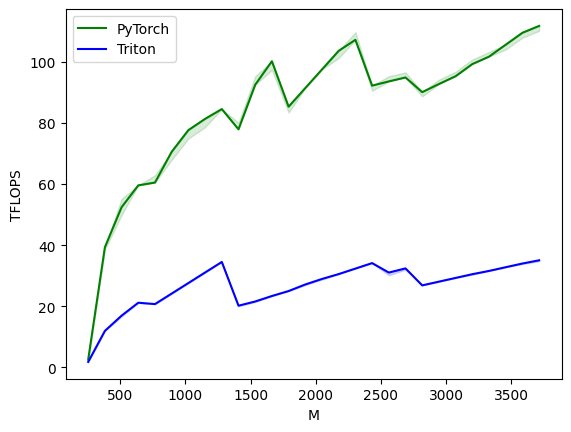

srp-performance-fp16:
         M     PyTorch     Triton
0    256.0    2.508555   1.759356
1    384.0   39.321601  11.915636
2    512.0   52.428801  16.912516
3    640.0   59.578181  21.140645
4    768.0   60.494770  20.695580
5    896.0   70.577232  24.144843
6   1024.0   77.672296  27.594106
7   1152.0   81.355032  31.043370
8   1280.0   84.562582  34.492633
9   1408.0   77.934699  20.164923
10  1536.0   92.521410  21.546081
11  1664.0  100.231528  23.341588
12  1792.0   85.349209  24.966095
13  1920.0   91.445581  27.118345
14  2048.0   97.541953  28.926235
15  2176.0  103.638326  30.523615
16  2304.0  107.240726  32.319122
17  2432.0   92.235852  34.114629
18  2560.0   93.622856  31.022957
19  2688.0   94.914205  32.382494
20  2816.0   90.112000  26.824038
21  2944.0   92.758646  28.043313
22  3072.0   95.325090  29.262587
23  3200.0   99.296969  30.481861
24  3328.0  101.727521  31.554370
25  3456.0  105.640118  32.768000
26  3584.0  109.552715  33.981630
27  3712.0  111.796704  35

In [30]:
benchmark.run(show_plots=True, print_data=True)